In [12]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import pickle
import numpy as np

import py21cmfast as p21c
from astropy.cosmology import Planck18

sys.path.append("..")
from dm21cm.dm_params import DMParams
from dm21cm.evolve import evolve
import dm21cm.physics as phys

sys.path.append(os.environ['DH_DIR'])
from darkhistory.main import evolve as evolve_DH

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colormaps as cms
mpl.rc_file('../matplotlibrc')

## DMParam

In [7]:
run_name = 'dhc_noinj'

dm_params = DMParams(
    mode = 'swave',
    primary = 'phot_delta',
    m_DM = 1e10,
    sigmav = 1e-50,
    struct_boost_model = 'erfc 1e-3',
)

## DarkHistory

In [8]:
soln = evolve_DH(
    DM_process=dm_params.mode, mDM=dm_params.m_DM,
    primary=dm_params.primary,
    sigmav=dm_params.sigmav, lifetime=dm_params.lifetime,
    struct_boost=dm_params.struct_boost,
    start_rs=3000, end_rs=5.+1, coarsen_factor=12, verbose=1,
    reion_switch=False
)

pickle.dump(soln, open(f"run_info/{run_name}_dh_soln.p", 'wb'))

Loading time: 0.000 s


  0%|          | 2/518 [00:00<00:47, 10.82it/s]

Initialization time: 0.039 s


100%|██████████| 518/518 [01:12<00:00,  7.11it/s]


Main loop time: 72.778 s


In [9]:
return_dict = evolve(
    run_name = run_name,
    z_start = 45.,
    z_end = 5.,
    zplusone_step_factor = 1.01,
    dm_params = dm_params,
    enable_elec = False,
    tf_version = '230629',
    
    p21c_initial_conditions = p21c.initial_conditions(
        user_params = p21c.UserParams(
            HII_DIM = 16,
            BOX_LEN = 16 * 4, # [conformal Mpc]
            N_THREADS = 32,
        ),
        cosmo_params = p21c.CosmoParams(
            OMm = Planck18.Om0,
            OMb = Planck18.Ob0,
            POWER_INDEX = Planck18.meta['n'],
            #SIGMA_8 = Planck18.meta['sigma8'],
            SIGMA_8 = 1e-8,
            hlittle = Planck18.h,
        ),
        random_seed = 54321,
        write = True,
    ),
    
    rerun_DH = False,
    clear_cache = True,
    use_tqdm = False,
    debug_flags = [],
    debug_xray_multiplier = 1.,
    debug_astro_params = p21c.AstroParams(
        L_X = 0. # log10 value
    ),
    save_dir='run_info',
)
        

/n/home07/yitians/.conda/envs/dm21cm/lib/python3.11/site-packages/py21cmfast/inputs.py:487: UserWarning: The USE_INTERPOLATION_TABLES setting has changed in v3.1.2 to be default True. You can likely ignore this warning, but if you relied onhaving USE_INTERPOLATION_TABLES=False by *default*, please set it explicitly. To silence this warning, set it explicitly to True. Thiswarning will be removed in v4.
  warnings.warn(
INFO:root:Using 21cmFAST version 0.1.dev1581+g40959ca
INFO:root:Cache dir: /n/holyscratch01/iaifi_lab/yitians/21cmFAST-cache/dhc_noinj
INFO:root:TransferFunctionWrapper: Loaded photon transfer functions.
INFO:root:DarkHistoryWrapper: Running DarkHistory to generate initial conditions...


Loading time: 0.000 s


  1%|          | 2/357 [00:00<00:30, 11.49it/s]

Initialization time: 0.023 s


100%|██████████| 357/357 [00:48<00:00,  7.43it/s]
INFO:root:DarkHistoryWrapper: Saved DarkHistory initial conditions.


Main loop time: 48.029 s
i_z=0/205 z=45.00 bath.toteng=9.575e-27 eV/Bavg
i_z=1/205 z=44.68 bath.toteng=9.506e-27 eV/Bavg
i_z=2/205 z=44.23 bath.toteng=9.410e-27 eV/Bavg
i_z=3/205 z=43.78 bath.toteng=9.314e-27 eV/Bavg
i_z=4/205 z=43.34 bath.toteng=9.220e-27 eV/Bavg
i_z=5/205 z=42.90 bath.toteng=9.128e-27 eV/Bavg
i_z=6/205 z=42.46 bath.toteng=9.036e-27 eV/Bavg
i_z=7/205 z=42.03 bath.toteng=8.945e-27 eV/Bavg
i_z=8/205 z=41.61 bath.toteng=8.855e-27 eV/Bavg
i_z=9/205 z=41.18 bath.toteng=8.765e-27 eV/Bavg
i_z=10/205 z=40.77 bath.toteng=8.677e-27 eV/Bavg
i_z=11/205 z=40.35 bath.toteng=8.590e-27 eV/Bavg
i_z=12/205 z=39.94 bath.toteng=8.503e-27 eV/Bavg
i_z=13/205 z=39.54 bath.toteng=8.418e-27 eV/Bavg
i_z=14/205 z=39.14 bath.toteng=8.333e-27 eV/Bavg
i_z=15/205 z=38.74 bath.toteng=8.249e-27 eV/Bavg
i_z=16/205 z=38.35 bath.toteng=8.166e-27 eV/Bavg
i_z=17/205 z=37.96 bath.toteng=8.084e-27 eV/Bavg
i_z=18/205 z=37.57 bath.toteng=8.003e-27 eV/Bavg
i_z=19/205 z=37.19 bath.toteng=7.922e-27 eV/Bavg
i_z=2

## compare

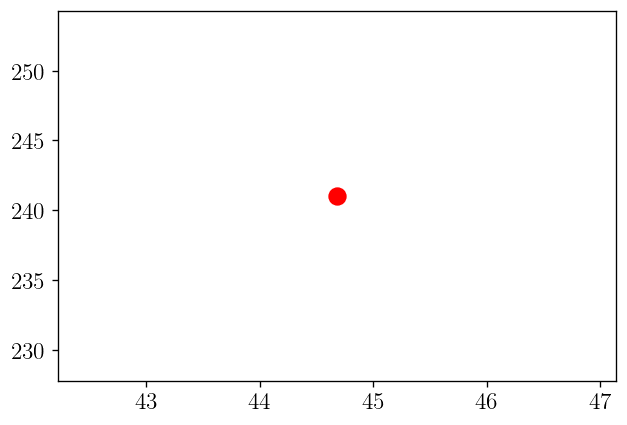

In [30]:
color_dict = {
    'DH' : 'k',
    '21' : 'r',
}
plt.plot(soln['z'][0], soln['T_k'][0], color=color_dict['21'], marker='o', markersize=10)

In [33]:
def plot_global(dh_soln, soln):
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))

    color_dict = {
        'DH' : 'k',
        '21' : 'r',
    }

    z_plot_start = 50.
    i_z_st = np.argmin(np.abs(dh_soln['rs']-1 - z_plot_start))
    ax = axs[0]
    ax.plot(dh_soln['rs'][i_z_st:] - 1, dh_soln['Tm'][i_z_st:]/phys.kB, color=color_dict['DH'], label='DarkHistory')
    ax.plot(soln['z'], soln['T_k'], color=color_dict['21'], ls=':', label='dm21cm')
    ax.plot(soln['z'][0], soln['T_k'][0], color=color_dict['21'], marker='o', ms=5)
    ax.set(xlim=(5, 50), xscale='log', yscale='log')
    ax.set(xlabel='$z$', ylabel='$T_k$ [K]', title='Gas temperature')
    ax.legend()

    ax = axs[1]
    ax.plot(dh_soln['rs'][i_z_st:] - 1, dh_soln['x'][i_z_st:, 0], color=color_dict['DH'], label='DarkHistory')
    ax.plot(soln['z'], soln['x_e'], color=color_dict['21'], ls=':', label='dm21cm')
    ax.plot(soln['z'][0], soln['x_e'][0], color=color_dict['21'], marker='o', ms=5)
    ax.set(xlim=(5, 50), xscale='log', yscale='log')
    ax.set(xlabel='$z$', ylabel='$x$', title='Ionization level')

    ax = axs[2]
    dh_bath_engs = [s.toteng() for s in dh_soln['highengphot']]
    ax.plot(dh_soln['rs'][i_z_st:] - 1, dh_bath_engs[i_z_st:], color=color_dict['DH'], label='DarkHistory')
    ax.plot(soln['z'], soln['E_phot'], color=color_dict['21'], ls=':', label='dm21cm')
    ax.plot(soln['z'][0], soln['E_phot'][0], color=color_dict['21'], marker='o', ms=5)
    ax.set(xlim=(5, 50), xscale='log', yscale='log')
    ax.set(xlabel='$z$', ylabel='$E$ [eV/Bavg]', title='Bath energy')

    ax = axs[3]
    ax.plot(soln['z'], soln['T_b'], color=color_dict['21'], ls=':', label='dm21cm')
    ax.set(xlim=(5, 50), xscale='log')
    ax.set(xlabel='$z$', ylabel='$T_b$ [K]', title='Brightness temperature')

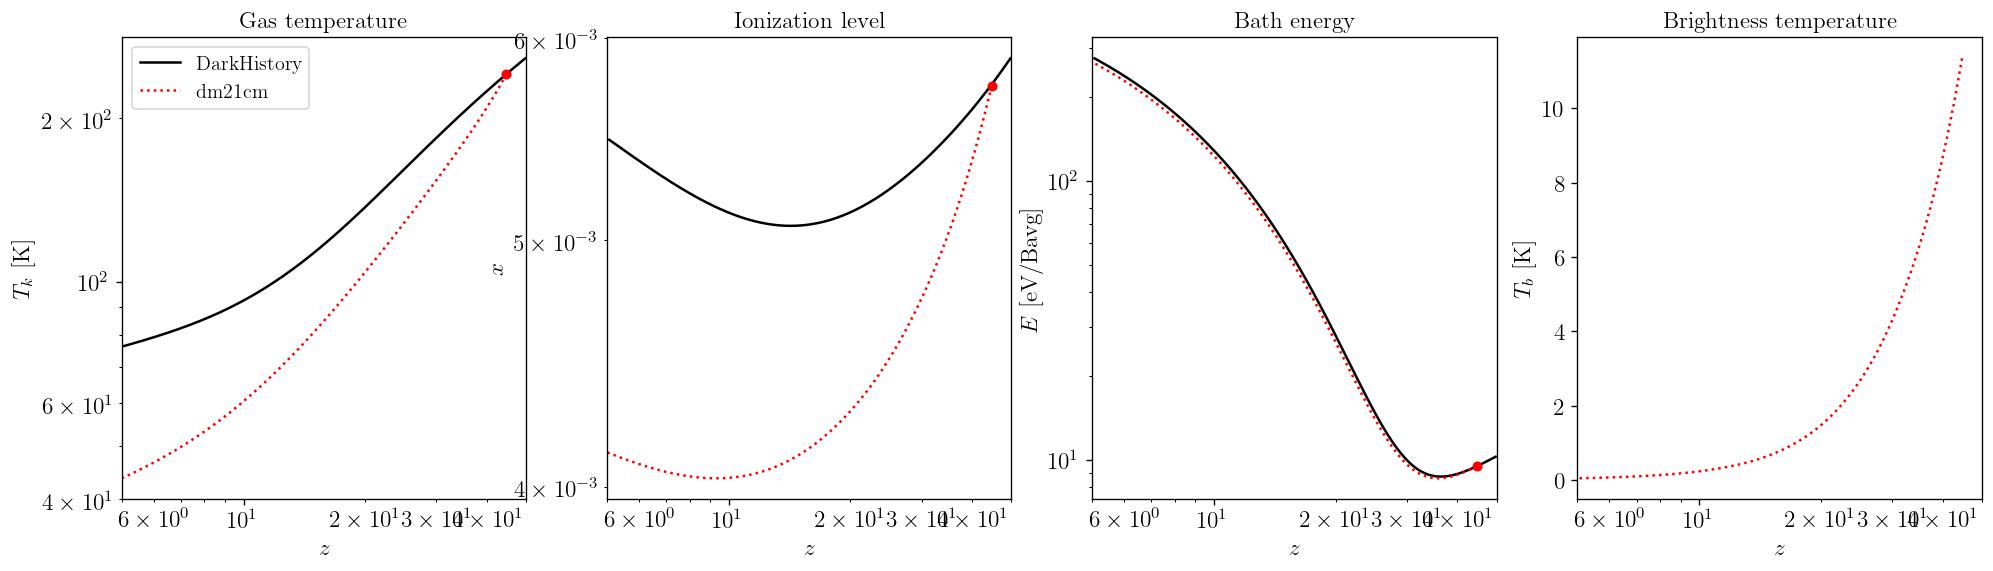

In [34]:
run_name = 'dhc_phph'
dh_soln = pickle.load(open(f"run_info/{run_name}_dh_soln.p", 'rb'))
soln = np.load(f"run_info/{run_name}_records.npy", allow_pickle=True).item()
plot_global(dh_soln, soln)

In [27]:
soln = pickle.load(open(os.environ['P21C_CACHE_DIR'] + '/' + run_name + '/dh_init_soln.p', 'rb'))

In [30]:
np.searchsorted(soln['rs'][::-1], 45)

7

In [31]:
soln['Tm'][::-1][7] / phys.kB

240.73062097369535

In [ ]:
spin_temp.Tk_box 41.490818
spin_temp.x_e_box 0.00021329575
ionized_box.xH_box 0.99978644
spin_temp.Tk_box 242.32993
spin_temp.x_e_box 0.005761361
ionized_box.xH_box 0.99423933
phot_bath_spec.toteng() 9.560496755492082